# Quantile regression

### Standard regression

In this example we do quantile regression in CVXPY.
We start by discussing standard regression.
In a regression problem we are given data $(x_i,y_i)\in {\bf R}^n \times {\bf R}$, $i=1,\ldots, m$.
and fit a linear (affine) model

$$\hat y_i = \beta ^Tx_i - v,$$

where $\beta \in {\bf R}^n$ and $v \in {\bf R}$.

The residuals are $r_i = \hat y_i - y_i$.
In standard (least-squares) regression we choose $\beta,v$ to minimize $\|r\|_2^2 = \sum_i r_i^2$.
For this choice of $\beta,v$ the mean of the optimal residuals is zero.

A simple variant is to add (Tychonov) regularization, meaning we solve the optimization problem

$$\begin{array}{ll}
\mbox{minimize} & \|r\|_2^2 + \lambda \|\beta \|_2^2,
\end{array}$$

where $\lambda>0$.

### Quantile regression

An alternative to the standard least-squares penalty is the *tilted $\ell_1$ penalty*: for $\tau \in (0,1)$,

$$
\phi(u)= \tau (u)_+ + (1-\tau) (u)_- = (1/2)|u| + (\tau-1/2) u.
$$

The plots below show $\phi(u)$ for $\tau= 0.5$, $\tau= 0.1$, and $\tau= 0.9$.

![title](https://github.com/cvxgrp/cvx_short_course/blob/master/applications/tilted_l1.png?raw=1)

In quantile regression we choose $\beta,v$ to minimize $\sum_i \phi(r_i)$.
For $r_i \neq 0$,

$$
\frac{\partial \sum_i \phi(r_i)}{\partial v} =
\tau \left|\{i: r_i>0\} \right| - (1-\tau) \left|\{i: r_i<0\}\right|,
$$

which means that (roughly speaking) for optimal $v$ we have

$$
\tau \left|\{i: r_i>0\} \right| = (1-\tau) \left|\{i: r_i<0\}\right|.
$$

We conclude that $\tau m = \left|\{i: r_i<0\}\right|$, or the $\tau$-quantile of optimal residuals is zero.
Hence the name quantile regression.

### Example

In the following code we apply quantile regression to a time series prediction problem.
We fit the time series $x_t$, $t=0,1,2, \ldots$ with an auto-regressive (AR) predictor


$$\hat x_{t+1} = \beta^T (x_t,\ldots, x_{t-M})- v,$$

where $M=10$ is the memory of predictor.

We use quantile regression for $\tau = 0.1,0.5, 0.9$ to fit three AR models.
At each time $t$, the models give three one-step-ahead predictions:

$$
\hat x_{t+1} ^{0.1}, \qquad
\hat x_{t+1} ^{0.5}, \qquad
\hat x_{t+1} ^{0.9}
$$

We divide the time series into a training set, which we use to fit the AR models, and a test set.
We plot $x_t$ and the predictions
$\hat x_{t+1} ^{0.1}$,
$\hat x_{t+1} ^{0.5}$,
$\hat x_{t+1} ^{0.9}$
for the training set and the test set.

In [0]:
# Generate data for quantile regression.
from __future__ import division
import numpy as np
np.random.seed(1)
TRAIN_LEN = 400
SKIP_LEN = 100
TEST_LEN = 50
TOTAL_LEN = TRAIN_LEN + SKIP_LEN + TEST_LEN
m = 10
x0 = np.random.randn(m)
x = np.zeros(TOTAL_LEN) 
x[:m] = x0
for i in range(m+1, TOTAL_LEN):
    x[i] = 1.8*x[i-1] - .82*x[i-2] + np.random.normal()
    
x = np.exp(.05*x + 0.05*np.random.normal(size=TOTAL_LEN))

In [0]:
# Form the quantile regression problem.
import cvxpy as cp


w = cp.Variable(m+1)
v = cp.Variable()
tau = cp.Parameter()
error = 0
for i in range(SKIP_LEN, TRAIN_LEN + SKIP_LEN):
    r = x[i] - (w.T*x[i-m-1:i] + v)
    error += 0.5*cp.abs(r) + (tau - 0.5)*r
prob = cp.Problem(cp.Minimize(error))

In [99]:
%%time
# Solve quantile regression for different values of tau.
tau_vals = [0.9, 0.5, 0.1]
pred = np.zeros((len(tau_vals), TOTAL_LEN))
r_vals = np.zeros((len(tau_vals), TOTAL_LEN))
for k, tau_val in enumerate(tau_vals):
    tau.value = tau_val
    prob.solve()
    pred[k,:m] = x0
    for i in range(SKIP_LEN, TOTAL_LEN):
        pred[k,i] = (x[i-m-1:i].T*w + v).value
        r_vals[k, i] = (x[i] - (x[i-m-1:i].T*w + v)).value

CPU times: user 3.79 s, sys: 0 ns, total: 3.79 s
Wall time: 3.79 s


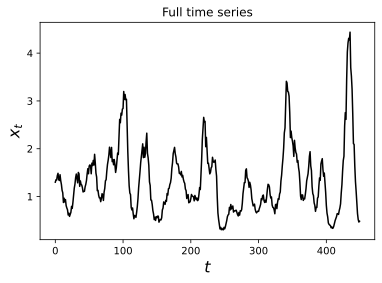

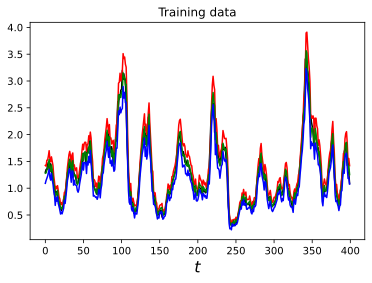

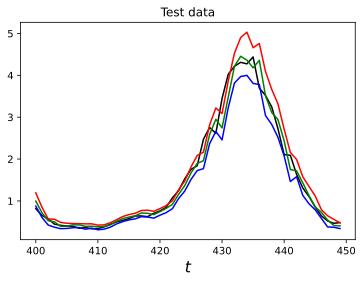

In [100]:
# Generate plots.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Plot the full time series.
plt.plot(range(0, TRAIN_LEN + TEST_LEN), x[SKIP_LEN:],  'black', label=r'$x$')
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$x_t$", fontsize=16)
plt.title('Full time series')
plt.show()

# Plot the predictions from the quantile regression on the training data.
plt.plot(range(0, TRAIN_LEN), x[SKIP_LEN:-TEST_LEN],  'black', label=r'$x$')
colors = ['r', 'g', 'b']
for k, tau_val in enumerate(tau_vals):
    plt.plot(range(0, TRAIN_LEN), pred[k,SKIP_LEN:-TEST_LEN], colors[k],  label=r"$\tau = %.1f$" % tau_val)
plt.xlabel(r"$t$", fontsize=16)
plt.title('Training data')
plt.show()

# Plot the predictions from the quantile regression on the test data.
plt.plot(range(TRAIN_LEN,TRAIN_LEN+TEST_LEN), x[-TEST_LEN:],  'black', label=r'$x$')
for k, tau_val in enumerate(tau_vals):
    plt.plot(range(TRAIN_LEN,TRAIN_LEN+TEST_LEN), pred[k,-TEST_LEN:], colors[k],  label=r"$\tau = %.1f$" % tau_val)
plt.xlabel(r"$t$", fontsize=16)
plt.title('Test data')
plt.show()

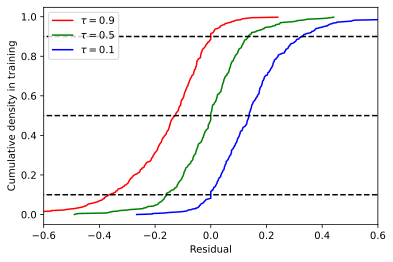

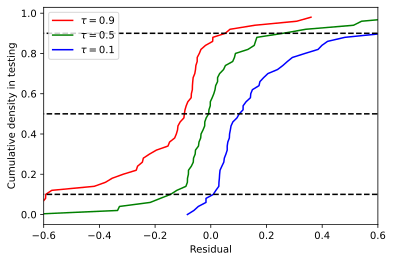

In [101]:
# Plot the empirical CDFs of the residuals.

# Plot the CDF for the training data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted=np.sort(r_vals[k,SKIP_LEN:SKIP_LEN+TRAIN_LEN] )
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1.0, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x)*[val], 'k--')
plt.xlabel('Residual')
plt.ylabel('Cumulative density in training')
plt.xlim([-0.6, 0.6])
plt.legend(loc='upper left')
plt.show()

# Plot the CDF for the testing data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted=np.sort(r_vals[k,-TEST_LEN:] )
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x)*[val], 'k--')
plt.xlabel('Residual')
plt.ylabel('Cumulative density in testing')
plt.xlim([-0.6, 0.6])
plt.legend(loc='upper left')
plt.show()

In [103]:
%%time
# Do similar thing in pytorch
import torch
import torch.nn as nn
# Generate data for quantile regression.
import numpy as np
np.random.seed(1)
TRAIN_LEN = 400
SKIP_LEN = 100
TEST_LEN = 50
TOTAL_LEN = TRAIN_LEN + SKIP_LEN + TEST_LEN
m = 10
x0 = np.random.randn(m)
x = np.zeros(TOTAL_LEN) 
x[:m] = x0
for i in range(m+1, TOTAL_LEN):
    x[i] = 1.8*x[i-1] - .82*x[i-2] + np.random.normal()
    
x = np.exp(.05*x + 0.05*np.random.normal(size=TOTAL_LEN))

class QuantReg(nn.Module):
    def __init__(self, m):
        super(QuantReg, self).__init__()
        self.m = m
        self.W = nn.Parameter(torch.zeros(self.m+1))
        self.V = nn.Parameter(torch.zeros(1))

    def forward(self, x, i):
        #print(torch.t(x[i-m-1:i]))
        #print(self.W)
        return torch.sum(torch.t(x[i-m-1:i]) * self.W) + self.V


class QuantileLoss(nn.Module):
    # adapted from https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629
    def __init__(self, tau):
        super().__init__()
        self.tau = tau
        
    def forward(self, preds, targets):
        assert not targets.requires_grad
        assert preds.size(0) == targets.size(0)
        losses = []
        for i, pr in enumerate(preds):
            error = targets[i] - preds[i]
            losses.append(torch.tensor(0.5) * torch.abs(error) + (self.tau - torch.tensor(0.5)) * error)
        loss = np.sum(losses)
        return loss


def solve_probl(model, loss, optim, scheduler, x, m, tau, epoch=1):
    for k in range(epoch):
        preds = torch.zeros(TRAIN_LEN)
        targets = torch.zeros(TRAIN_LEN)
        for i in range(SKIP_LEN, TRAIN_LEN + SKIP_LEN):
            preds[i - SKIP_LEN] = model(torch.tensor(x), i)
            targets[i - SKIP_LEN] = torch.tensor(x[i])
        optim.zero_grad()
        scheduler.step()
        cur_loss = loss(preds, targets)
        cur_loss.backward()
        optim.step()
        #print(cur_loss.detach().numpy())
    return model


model = QuantReg(m)

tau_vals = [0.9, 0.5, 0.1]
pred = np.zeros((len(tau_vals), TOTAL_LEN))
r_vals = np.zeros((len(tau_vals), TOTAL_LEN))
for k, tau_val in enumerate(tau_vals):
    loss = QuantileLoss(tau_val)
    model = QuantReg(m)
    optim = torch.optim.SGD(model.parameters(),lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=200, gamma=0.1)
    model = solve_probl(model, loss, optim, scheduler, x, m, tau_val, epoch=400)
    #tau.value = tau_val
    #prob.solve()
    pred[k,:m] = x0
    for i in range(SKIP_LEN, TOTAL_LEN):
        #print(model(torch.tensor(x), i).detach().numpy())
        pred[k,i] = model(torch.tensor(x), i).detach().numpy()#(x[i-m-1:i].T*w + v).value
        r_vals[k, i] = (x[i] - pred[k, i])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


CPU times: user 1min 53s, sys: 134 ms, total: 1min 53s
Wall time: 1min 54s


Below we plot the full time series, the training data with the three AR models, and the test data with the three AR models.

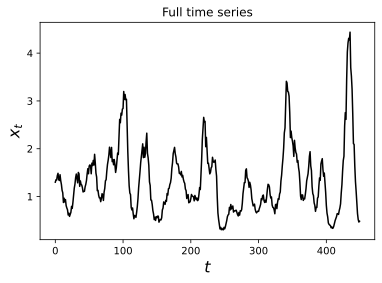

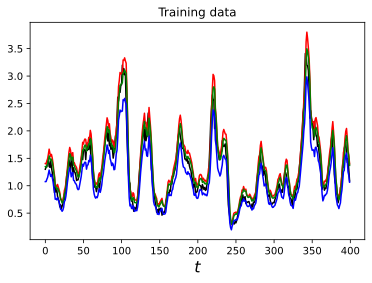

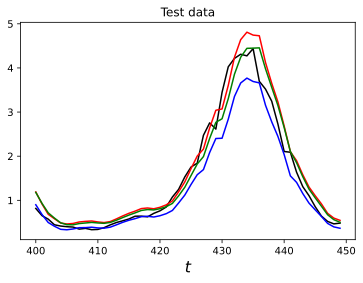

In [104]:
# Generate plots.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Plot the full time series.
plt.plot(range(0, TRAIN_LEN + TEST_LEN), x[SKIP_LEN:],  'black', label=r'$x$')
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$x_t$", fontsize=16)
plt.title('Full time series')
plt.show()

# Plot the predictions from the quantile regression on the training data.
plt.plot(range(0, TRAIN_LEN), x[SKIP_LEN:-TEST_LEN],  'black', label=r'$x$')
colors = ['r', 'g', 'b']
for k, tau_val in enumerate(tau_vals):
    plt.plot(range(0, TRAIN_LEN), pred[k,SKIP_LEN:-TEST_LEN], colors[k],  label=r"$\tau = %.1f$" % tau_val)
plt.xlabel(r"$t$", fontsize=16)
plt.title('Training data')
plt.show()

# Plot the predictions from the quantile regression on the test data.
plt.plot(range(TRAIN_LEN,TRAIN_LEN+TEST_LEN), x[-TEST_LEN:],  'black', label=r'$x$')
for k, tau_val in enumerate(tau_vals):
    plt.plot(range(TRAIN_LEN,TRAIN_LEN+TEST_LEN), pred[k,-TEST_LEN:], colors[k],  label=r"$\tau = %.1f$" % tau_val)
plt.xlabel(r"$t$", fontsize=16)
plt.title('Test data')
plt.show()

Below we plot the empirical CDFs of the residuals for the three AR models on the training data and the test data.
Notice that $\tau$-quantile of the optimal residuals is close to zero.

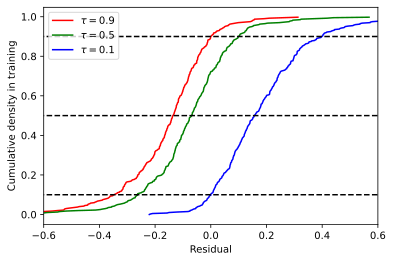

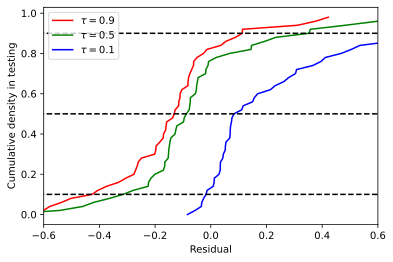

In [105]:
# Plot the empirical CDFs of the residuals.

# Plot the CDF for the training data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted=np.sort(r_vals[k,SKIP_LEN:SKIP_LEN+TRAIN_LEN] )
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1.0, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x)*[val], 'k--')
plt.xlabel('Residual')
plt.ylabel('Cumulative density in training')
plt.xlim([-0.6, 0.6])
plt.legend(loc='upper left')
plt.show()

# Plot the CDF for the testing data residuals.
for k, tau_val in enumerate(tau_vals):
    sorted=np.sort(r_vals[k,-TEST_LEN:] )
    yvals=np.arange(len(sorted))/float(len(sorted))
    plt.plot( sorted, yvals, colors[k], label=r"$\tau = %.1f$" % tau_val)

x = np.linspace(-1, 1, 100)
for val in [0.1, 0.5, 0.9]:
    plt.plot(x, len(x)*[val], 'k--')
plt.xlabel('Residual')
plt.ylabel('Cumulative density in testing')
plt.xlim([-0.6, 0.6])
plt.legend(loc='upper left')
plt.show()